<a href="https://colab.research.google.com/github/aldonat/WebDeteksiKankerKulit/blob/main/Klasifikasi_Kanker_Kulit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Library

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

#Load Dataset

In [6]:
data= pd.read_csv('/content/drive/MyDrive/SIB - Bisa AI Academy/Capstone Project/dataset/HAM10000_metadata.csv')
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


#Data Visualization

<ipython-input-8-a326c4e75b6a>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


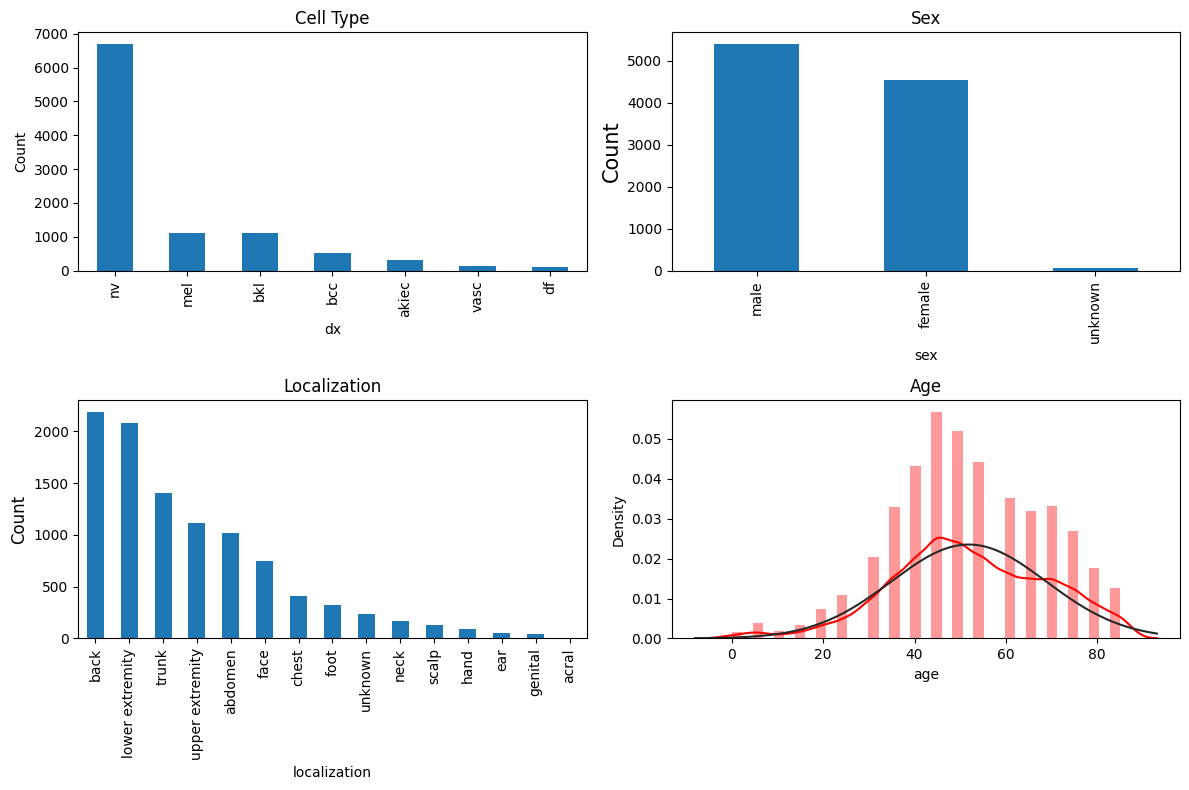

In [8]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
data['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
data['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
data['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = data[pd.notnull(data['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [9]:
data['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

#Data Balancing

In [10]:
# applied only on the training set
df = data.groupby('dx').apply(lambda x: x.sample(500, replace=True))
df = df.reset_index(drop=True)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0004522,ISIC_0028381,akiec,histo,55.0,female,neck
1,HAM_0001460,ISIC_0025637,akiec,histo,75.0,male,face
2,HAM_0005354,ISIC_0026625,akiec,histo,60.0,male,face
3,HAM_0007601,ISIC_0027536,akiec,histo,65.0,male,upper extremity
4,HAM_0002158,ISIC_0025411,akiec,histo,50.0,male,upper extremity


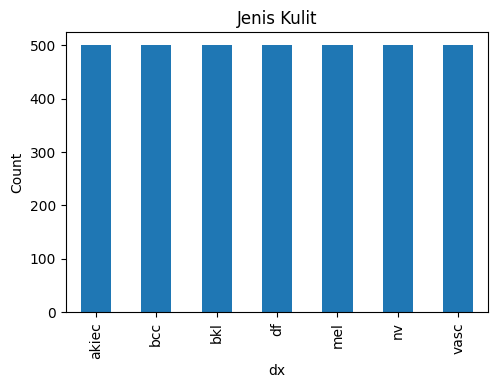

In [11]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Jenis Kulit');

plt.show()

#Prepocess Image

In [12]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/SIB - Bisa AI Academy/Capstone Project/dataset/reorganized/', '*', '*.jpg'))}
df['path']=df['image_id'].map(image_path.get)
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [13]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

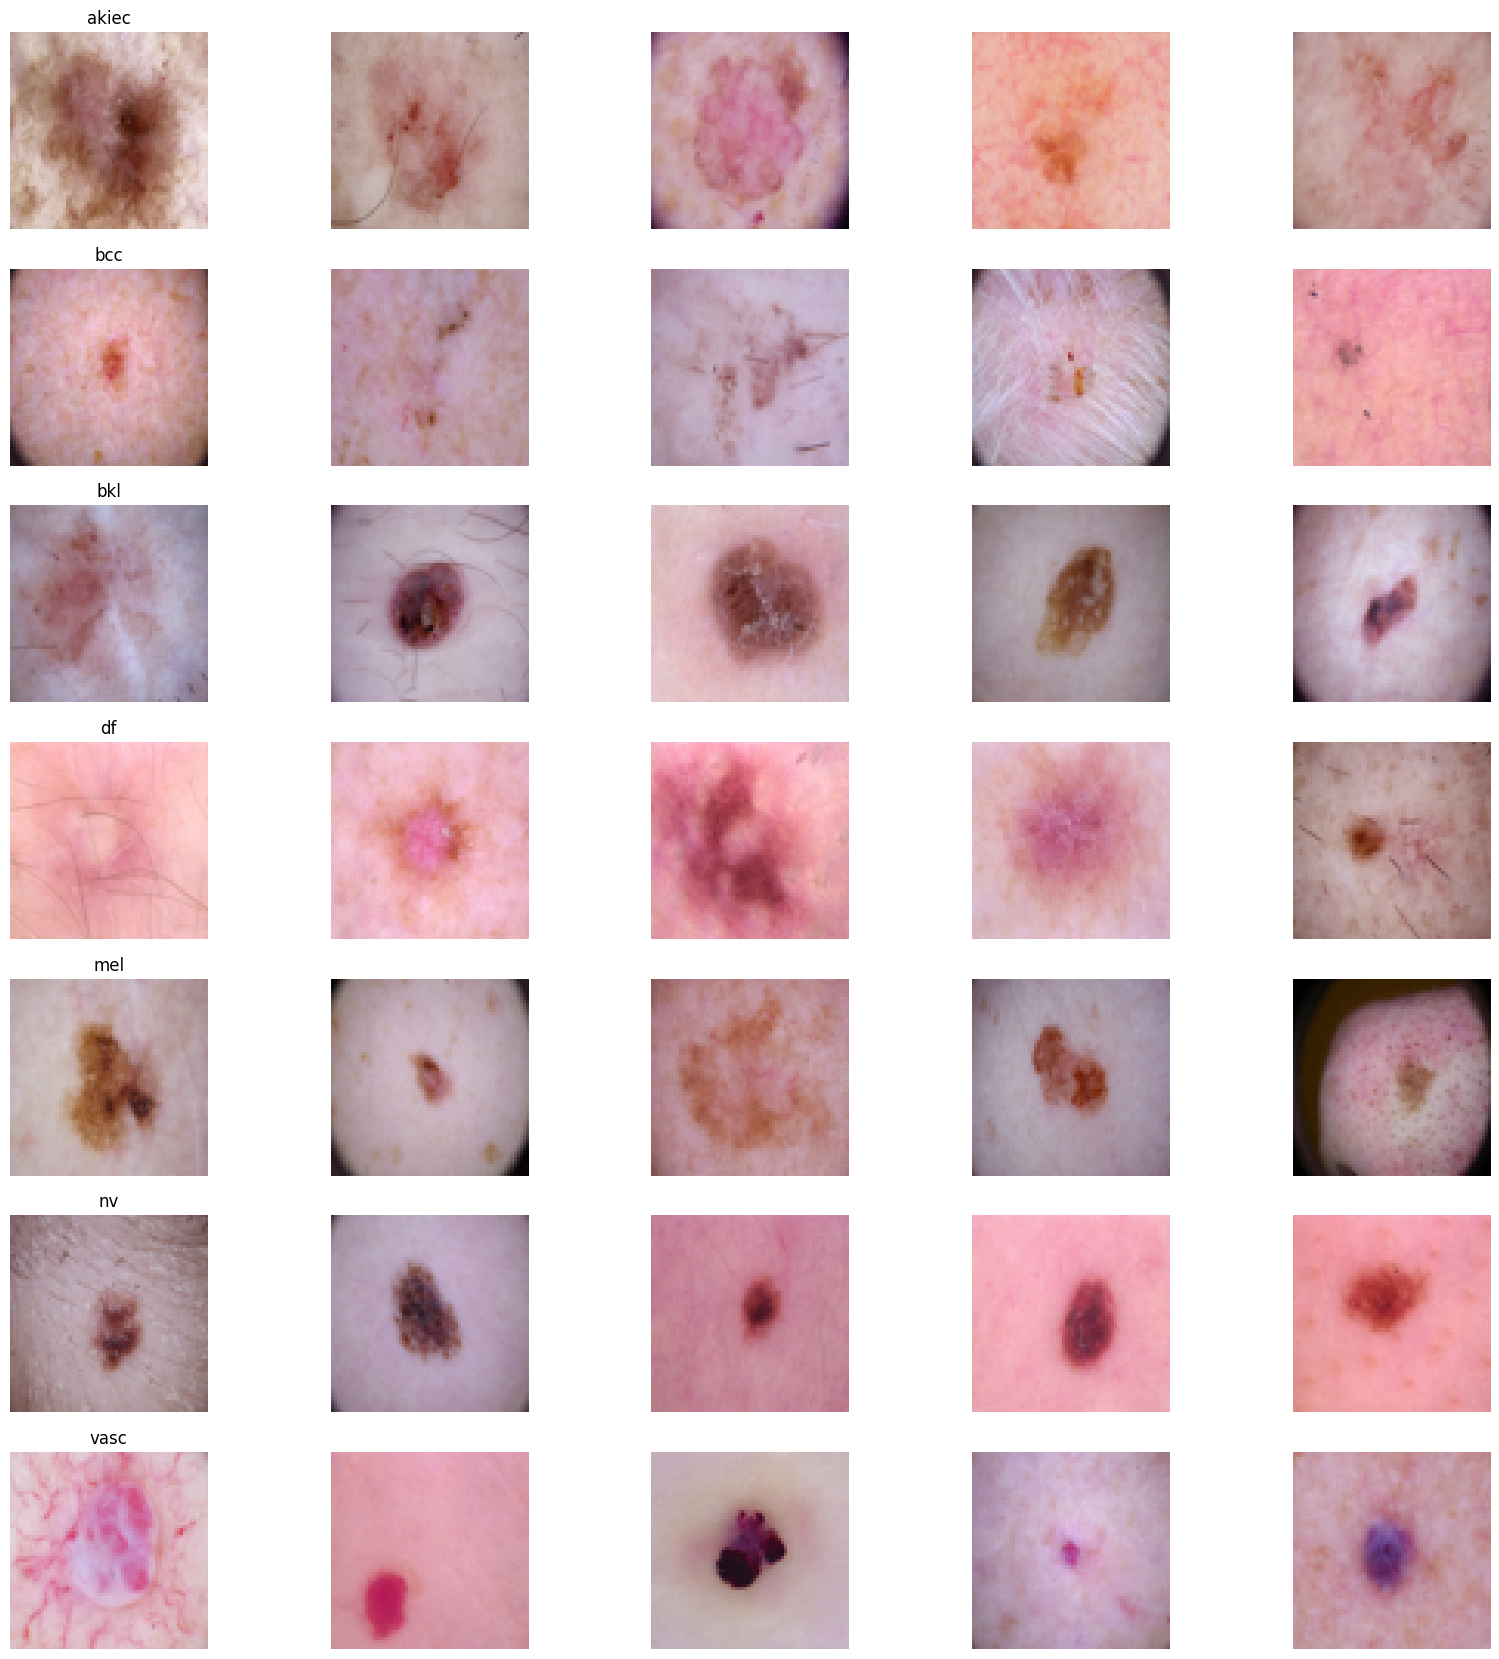

In [14]:
n_samples = 5
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

#Encode Labels

In [15]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['dx'])
LabelEncoder()
print(list(le.classes_))
df['label'] = le.transform(df["dx"])
df.head()

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
0,HAM_0004522,ISIC_0028381,akiec,histo,55.0,female,neck,/content/drive/MyDrive/SIB - Bisa AI Academy/C...,"[[[176, 148, 135], [185, 161, 150], [191, 170,...",0
1,HAM_0001460,ISIC_0025637,akiec,histo,75.0,male,face,/content/drive/MyDrive/SIB - Bisa AI Academy/C...,"[[[142, 105, 98], [145, 108, 102], [152, 118, ...",0
2,HAM_0005354,ISIC_0026625,akiec,histo,60.0,male,face,/content/drive/MyDrive/SIB - Bisa AI Academy/C...,"[[[186, 119, 143], [188, 118, 152], [196, 134,...",0
3,HAM_0007601,ISIC_0027536,akiec,histo,65.0,male,upper extremity,/content/drive/MyDrive/SIB - Bisa AI Academy/C...,"[[[173, 138, 137], [175, 137, 132], [175, 132,...",0
4,HAM_0002158,ISIC_0025411,akiec,histo,50.0,male,upper extremity,/content/drive/MyDrive/SIB - Bisa AI Academy/C...,"[[[166, 136, 121], [169, 137, 122], [177, 146,...",0


#Split Data

In [16]:
X = np.asarray(df['image'].tolist())
X = X/255.
Y=df['label']
Y_cat = to_categorical(Y, num_classes=7)
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [17]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(2625, 64, 64, 3) (875, 64, 64, 3)
(2625, 7) (875, 7)


#Data Augmentasi

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

#CNN Model

In [19]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(64, 64, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [22]:
epochs=100
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = 16,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/100
165/165 - 156s - loss: 1.8618 - acc: 0.2145 - val_loss: 1.8022 - val_acc: 0.2914 - 156s/epoch - 948ms/step
Epoch 2/100
165/165 - 160s - loss: 1.7503 - acc: 0.2552 - val_loss: 1.9397 - val_acc: 0.2457 - 160s/epoch - 970ms/step
Epoch 3/100
165/165 - 170s - loss: 1.7266 - acc: 0.2659 - val_loss: 1.8044 - val_acc: 0.2766 - 170s/epoch - 1s/step
Epoch 4/100
165/165 - 161s - loss: 1.6212 - acc: 0.3352 - val_loss: 1.6206 - val_acc: 0.3851 - 161s/epoch - 978ms/step
Epoch 5/100
165/165 - 161s - loss: 1.4415 - acc: 0.4118 - val_loss: 1.4688 - val_acc: 0.4617 - 161s/epoch - 974ms/step
Epoch 6/100
165/165 - 158s - loss: 1.3790 - acc: 0.4263 - val_loss: 1.3187 - val_acc: 0.4846 - 158s/epoch - 959ms/step
Epoch 7/100
165/165 - 155s - loss: 1.3008 - acc: 0.4758 - val_loss: 1.3536 - val_acc: 0.4743 - 155s/epoch - 938ms/step
Epoch 8/100
165/165 - 161s - loss: 1.2698 - acc: 0.4804 - val_loss: 1.2798 - val_acc: 0.4971 - 161s/epoch - 979ms/step
Epoch 9/100
165/165 - 161s - loss: 1.2307 - acc: 0.

In [23]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 24s 870ms/step - loss: 0.9476 - acc: 0.7874
Test accuracy: 0.7874285578727722


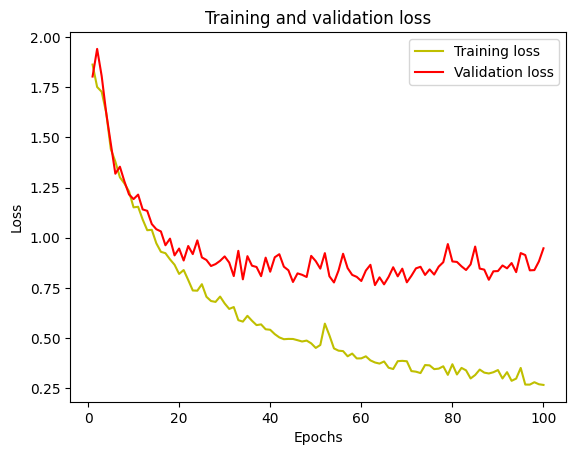

In [24]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

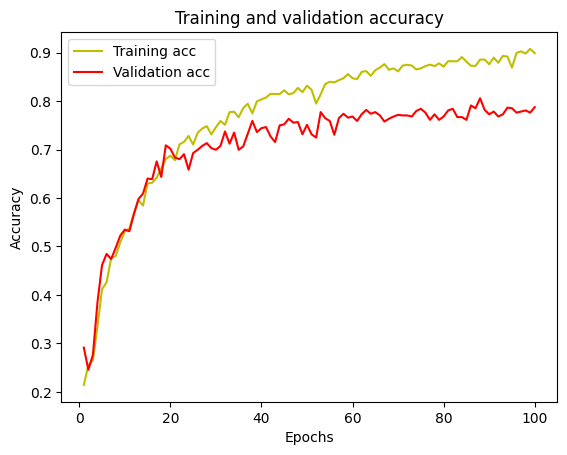

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Prediction on test data
y_pred = model.predict(x_test)
y_true = np.argmax(y_test, axis = 1)
# Convert predictions classes to one hot vectors
y_pred_lb = np.argmax(y_pred, axis = 1)


28/28 [==============================] - 14s 496ms/step


In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_lb)
print(cm)

[[114   7  14   6   7   1   0]
 [  9  82  21   8   2   3   3]
 [  7   5  85   2  11   7   3]
 [  1   0   0 127   0   0   0]
 [  8   1  16   1  70  15   1]
 [  3   1   7   3   8  87   4]
 [  0   0   0   1   0   0 124]]


In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
class_labels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
# Generate classification report
report = classification_report(y_true, y_pred_lb,target_names=class_labels)

# Print the report
print(report)

              precision    recall  f1-score   support

       akiec       0.80      0.77      0.78       149
         bcc       0.85      0.64      0.73       128
         bkl       0.59      0.71      0.65       120
          df       0.86      0.99      0.92       128
         mel       0.71      0.62      0.67       112
          nv       0.77      0.77      0.77       113
        vasc       0.92      0.99      0.95       125

    accuracy                           0.79       875
   macro avg       0.79      0.78      0.78       875
weighted avg       0.79      0.79      0.78       875



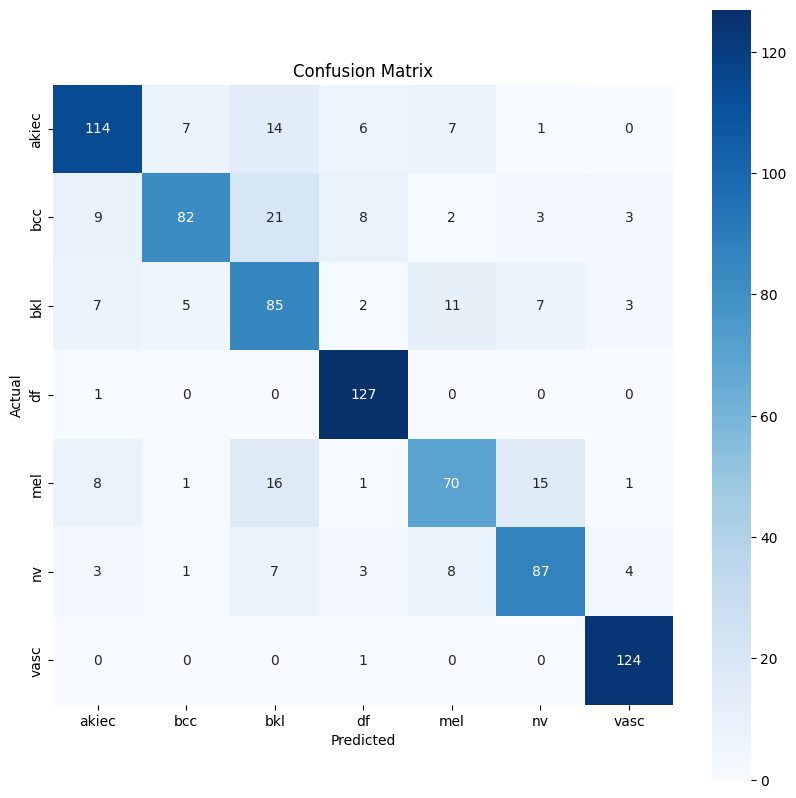

In [30]:

# Convert confusion matrix to DataFrame for plotting
cm_plot = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm_plot, annot=True, fmt="d", cmap="Blues", cbar=True, square=True)

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()


In [ ]:
model.save('kanker2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
